# Calibrate a LISFLOOD reservoir
***

**Autor:** Chus Casado<br>
**Date:** 31-10-2023<br>

**To do:**<br>
* [ ] Clean observed time series

**Questions:**<br>
* [ ] Why only some of the iterations are saved in the CSV file?
* [ ] What's the relation between likelihood and KGE?
* [ ] Fit the $Q_{min}$ based on the inflow data. Hot to fit a GEV to minima.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
import spotpy
from spotpy.objectivefunctions import kge
import yaml
from pathlib import Path
from tqdm.notebook import tqdm
import glob
# import cartopy.crs as ccrs
# import cartopy.feature as cf

from spot_setup_lisflood import spot_setup3, spot_setup5
from reservoirs import Lisflood

## Configuration

In [2]:
with open('config_extraction.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

path_res = Path(cfg['path_res'])
path_ts = Path(cfg['path_ts'])
# path_out = Path(cfg['path_out'])
# if path_out.exists() is False:
#     path_out.mkdir()
# var = cfg['var']

path_datasets = Path('Z:/nahaUsers/casadje/datasets/')

# study period
start = cfg['period']['start']
end = cfg['period']['end']

# # config plots
# proj = ccrs.PlateCarree()
# extent = [-125, -67.5, 24, 51]

# plots will be saved in this path
path_out = Path('GloFAS')
if path_out.exists() is False:
    path_out.mkdir()

In [3]:
# # config plots
# proj = ccrs.PlateCarree()
# extent = [-125, -67.5, 24, 51]

In [4]:
# # sequential mode
# parallel = "seq"  

# # input file
# input_file = f'reservoirs/input_{ResID:03}.csv'

# # output file
# output_file = 'reservoirs/SCEUA_burek'

## Data

### Base layers

In [5]:
# catchment_pol = gpd.read_file('../GIS/catchments_US.shp')
# catchment_pol = catchment_pol.to_crs(proj)#'epsg:4326')

### GloFAS

#### Reservoirs

In [6]:
# load shapefile of GloFAS reservoirs
reservoirs = gpd.read_file('../data/reservoirs/GloFAS/GloFAS_reservoirs.shp') 
reservoirs.set_index('ResID', drop=True, inplace=True)
reservoirs.rename(columns={'stor': 'CAP_GLWD'}, inplace=True)

# select only those reservoirs included in ResOpsUS
resopsus = gpd.read_file('../GIS/reservoirs_GloFAS_ResOpsUS.shp')
resopsus.set_index('ResID', drop=True, inplace=True)
mask = reservoirs.index.intersection(resopsus.index)
reservoirs = reservoirs.loc[mask]
reservoirs.GRAND_ID = reservoirs.GRAND_ID.astype(int)

print(f'{reservoirs.shape[0]} reservoirs')

112 reservoirs


#### Time series

In [7]:
# read GloFAS time series
path = Path('../data/reservoirs/GloFAS/long_run')
glofas_ts = {}
for file in tqdm(glob.glob(f'{path}/*.csv')):
    id = int(file.split('\\')[-1].split('.')[0].lstrip('0'))
    if id not in reservoirs.index:
        continue
    glofas_ts[id] = pd.read_csv(file, parse_dates=True, dayfirst=False, index_col='date')
    
print(f'{len(glofas_ts)} reservoirs')

  0%|          | 0/143 [00:00<?, ?it/s]

106 reservoirs


In [8]:
# check if reservoirs are missing
missing_reservoirs = reservoirs.index.difference(glofas_ts)
if len(missing_reservoirs) > 0:
    print(f'{len(missing_reservoirs)} reservoirs were not simulated in GloFAS')
    print(*missing_reservoirs)
reservoirs.drop(missing_reservoirs, axis=0, inplace=True)

6 reservoirs were not simulated in GloFAS
68 179 185 197 296 323


In [9]:
# # normalize inflow/outflow by the non-damaging outflow
# for id, df in glofas_ts.items():
#     df[['inflow', 'outflow']] /= reservoirs.loc[id, 'ndq']

#### Model parameters

In [10]:
# load static map of reservoirs
glofas_raster = xr.open_dataset(path_res)['res']

# extract an array of reservoir ID
ids = reservoirs.index.to_list()

# xr.DataArrays of reservoir longitudes and latitudes
lon = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
lat = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
for id in tqdm(ids):
    cell = glofas_raster.where(glofas_raster == id, drop=True)
    lon.loc[dict(ResID=id)] = cell.lon.data[0]
    lat.loc[dict(ResID=id)] = cell.lat.data[0]
coords = xr.Dataset({'lon': lon, 'lat': lat})

# extract parameter values
for par in ['adjustNormalFlood', 'ReservoirRnormqMult']:
    # load parameter map
    da = xr.open_dataset(f'Z:/nahaUsers/casadje/GloFASv4/parameters/{par}_GloFASv40.nc')[par]
    # extract values for each reservoir
    reservoirs[par] = da.sel(lon=lon, lat=lat, method='nearest').drop(['lon', 'lat']).to_pandas()

  0%|          | 0/106 [00:00<?, ?it/s]

In [11]:
# adjust normal limit and outflow with the calibrated parameters
reservoirs['nlim_adj'] = reservoirs.nlim + reservoirs.adjustNormalFlood * (reservoirs.flim - reservoirs.nlim)
reservoirs['normq_adj'] = pd.concat((reservoirs.normq * reservoirs.ReservoirRnormqMult, reservoirs.minq + .01), axis=1).max(axis=1)

### GRanD
#### Reservoirs

The shapefile of reservoirs in the GRanD data set is loaded to extract only the reservoir capacity reported in it.

In [12]:
# load GRanD data set
path_GRanD = path_datasets / 'reservoirs/GRanD/v1_3/'
grand = gpd.read_file(path_GRanD / 'grand_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=True, inplace=True)
grand = grand.replace(-99, np.nan)

# add GRanD capacity to the reservoirs
reservoirs['CAP_GRAND'] = grand.loc[reservoirs.GRAND_ID, 'CAP_MCM'].values

### ResOpsUS
#### Time series

In [13]:
path_ResOps = Path(path_datasets / 'reservoirs' / 'ResOpsUS')

resops_ts = {}
for glofas_id in tqdm(reservoirs.index):
    # load timeseries
    grand_id = reservoirs.loc[glofas_id, 'GRAND_ID']
    series_id = pd.read_csv(path_ResOps / 'time_series_all' / f'ResOpsUS_{grand_id}.csv', parse_dates=True, index_col='date')
    # remove empty time series
    series_id = series_id.loc[start:end]#.dropna(axis=1, how='all')
    # remove duplicated index
    series_id = series_id[~series_id.index.duplicated(keep='first')]
    # save in dictionary
    resops_ts[glofas_id] = series_id

  0%|          | 0/106 [00:00<?, ?it/s]

In [14]:
# approximate the ResOpsUS reservoir capacity as the maximum value in the records
reservoirs['CAP_RESOPS'] = pd.Series({id: df.storage.max() for id, df in resops_ts.items()})

In [15]:
# convert storage from hm3 to m3
for id, df in resops_ts.items():
    df.storage *= 1e6

### Correct reservoir capacity

In [16]:
try:
    # import DataFrame with the fraction fill and the selected data source
    ff = pd.read_excel('fraction_fill.xlsx', index_col='ResID')
except:
    # create DataFrame with the fraction fill according to each data source
    ff = pd.DataFrame(columns=['GLOFAS', 'GRAND'], dtype=float)
    ff.index.name = 'ResID'
    for id in reservoirs.index:
        cap_resops, cap_glofas, cap_grand = reservoirs.loc[id, ['CAP_RESOPS', 'CAP_GLWD', 'CAP_GRAND']]
        if np.isnan(cap_resops):
            continue
        ff.loc[id, :] = cap_resops / cap_glofas, cap_resops / cap_grand
    # export
    ff.to_excel('fraction_fill.xlsx', index=True)

In [17]:
# define de capacity  ('CAP') as that of the most reliable source
reservoirs['CAP'] = np.nan
for id in reservoirs.index:
    if ff.loc[id, 'selection'] == 'GLOFAS':
        reservoirs.loc[id, 'CAP'] = reservoirs.loc[id, 'CAP_GLWD']
    elif ff.loc[id, 'selection']:
        reservoirs.loc[id, 'CAP'] = reservoirs.loc[id, 'CAP_GRAND']

In [18]:
# convert storage time series into volume
for id, df in glofas_ts.items():
    df.storage *= reservoirs.loc[id, 'CAP'] * 1e6

## Reservoir

In [19]:
# GloFAS reservoir
ResID = 146 #302 #273 #236 #227

# storage limits
Vc, Vn, Vn_adj, Vf, Vtot = reservoirs.loc[ResID, ['clim', 'nlim', 'nlim_adj', 'flim', 'CAP']]
Vtot *= 1e6
Vc, Vn, Vn_adj, Vf = np.array([Vc, Vn, Vn_adj, Vf]) * Vtot

# outflow limits
Qmin, Qn, Qn_adj, Qnd = reservoirs.loc[ResID, ['minq', 'normq', 'normq_adj', 'ndq']]

# declare the reservoir
reservoir = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn_adj, Qnd)

In [20]:
# observed and LISFLOOD simulated time series
obs = resops_ts[ResID][['storage', 'inflow', 'outflow']].copy()
obs[obs[['inflow', 'outflow']] < 0] = np.nan

sim_glofas = glofas_ts[ResID][['storage', 'inflow', 'outflow']]

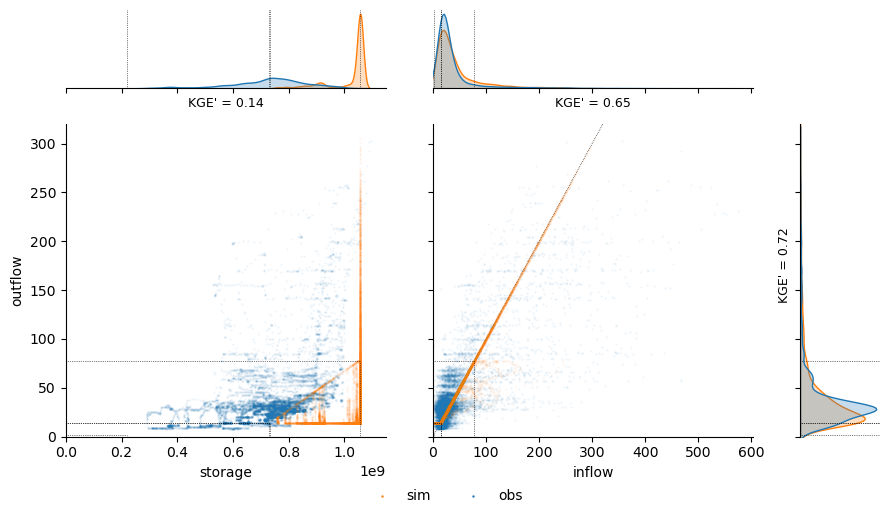

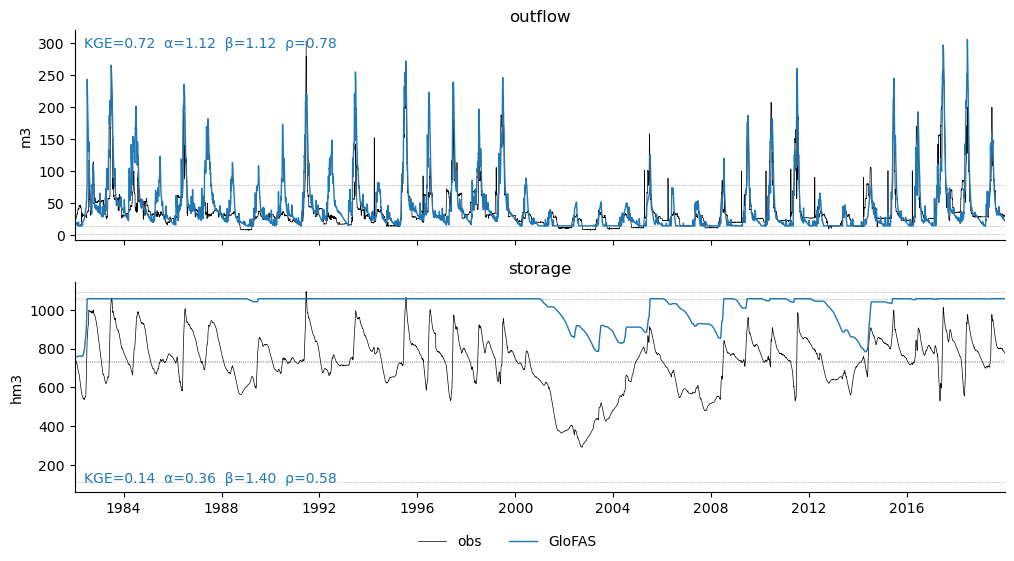

In [57]:
sim = reservoir.simulate(sim_glofas.inflow, obs.storage[0], routine=1, limit_Q=True, k=1)
reservoir.scatter(sim, obs, norm=False)
reservoir.lineplot({'GloFAS': sim}, obs)
#reservoir.lineplot({'GloFAS': sim_glofas, 'Lisflood': sim}, obs)

In [22]:
reservoirs.loc[ResID, ['adjustNormalFlood', 'ReservoirRnormqMult']]

adjustNormalFlood         0.01
ReservoirRnormqMult    1.59126
Name: 146, dtype: object

## Calibration
### Setup

In [23]:
# calibration period
start, end = datetime(2000, 1, 1), datetime(2019, 12, 31)

In [24]:
path_cal = Path('./calibration')
if path_cal.exists() is False:
    path_cal.mkdir()

# initialize the calibration setup of the LISFLOOD reservoir routine
#setup = spot_setup3(sim_glofas.inflow[start:end], obs.storage[start], sim_glofas.outflow[start:end],
#                   Vc, Vn, Vf, Vtot,
#                   Qmin, Qn, Qnd,
#                   spotpy.objectivefunctions.kge)

# initialize the calibration setup of the LISFLOOD reservoir routine
setup = spot_setup5(sim_glofas.inflow[start:end], obs.storage[start], sim_glofas.outflow[start:end],
                   Vc, Vtot, Qmin,
                   spotpy.objectivefunctions.kge)

In [25]:
# Select number of maximum allowed repetitions
max_iter = 2000
sampler = spotpy.algorithms.sceua(setup, dbname=f'{path_cal}/SCEUA_{ResID:03}', dbformat='csv', save_sim=True)

### Launch

In [26]:
# Start the sampler, one can specify ngs, kstop, peps and pcento id desired
sampler.sample(max_iter, ngs=7, kstop=10, peps=0.1, pcento=0.01)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  2000  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'calibration/SCEUA_146.csv' created.
4 of 2000, minimal objective function=0.0671938, time remaining: 00:14:18
8 of 2000, minimal objective function=0.0586012, time remaining: 00:15:44
12 of 2000, minimal objective function=0.0558647, time remaining: 00:16:26
16 of 2000, minimal objective function=0.0435107, time remaining: 00:16:34
20 of 2000, minimal objective function=0.0435107, time remaining: 00:16:36
24 of 2000, minimal objective function=0.0435107, time remaining: 00:16:39
28 of 2000, minimal objective function=0.0435107, time remaining: 00:16:42
32 of 2000, minimal objective function=0.0435107, time remaining: 00:16:46
36 of 2000, minimal objective function=0.0435107, time remaining: 00:16:49
40 of 2000, minimal objective function=0.0

### Analyse results 

In [27]:
# read CSV of results
#results = pd.read_csv(f'{path_cal}/SCEUA_{ResID:03}_3pars.csv')
#results.index.name = 'iteration'

# extract parameter values and likelihood
#pars = results[['like1', 'paralpha', 'parbeta', 'park', 'chain']].copy()
#pars.columns = [x[3:] if x.startswith('par') else x for x in pars.columns]

# extract simulation
#simulation = results.filter(regex='^simulation_').transpose()
#simulation.index = pd.date_range(start, end, freq='D')

# compute KGE of each simulation
#pars['KGE'] = [kge(obs.loc[start:end, 'outflow'], simulation[i]) for i in pars.index]

#del results

In [55]:
# declare the reservoir
#Vn_adj = Vn + alpha * (Vf - Vn)
#Qn_adj = min(Qnd, max(Qn * beta, Qmin + .01))
#res_cal = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn_adj, Qnd)

# simulate calibration period and get performance
#y_train = res_cal.simulate(glofas_ts[ResID].inflow[start:end], resops_ts[ResID].storage[start], k=k)
#res_cal.scatter(y_train, obs.loc[start:end], norm=False)
#res_cal.lineplot({'cal': y_train}, obs.loc[start:end])

# simulate calibration period and get performance
#y_test = res_cal.simulate(glofas_ts[ResID].inflow[:start], resops_ts[ResID].storage.iloc[0], k=k)
#res_cal.scatter(y_test, obs.loc[:start], norm=False)
#res_cal.lineplot({'val': y_test}, obs)

In [34]:
# read CSV of results
results = pd.read_csv(f'{path_cal}/SCEUA_{ResID:03}_5pars.csv')
results.index.name = 'iteration'

# extract parameter values and likelihood
cols = ['like1'] + [col for col in results.columns if col.startswith('par')] + ['chain']
pars = results[cols].copy()
pars.columns = [x[3:] if x.startswith('par') else x for x in pars.columns]

# extract simulation
simulation = results.filter(regex='^simulation_').transpose()
simulation.index = pd.date_range(start, end, freq='D')

# compute KGE of each simulation
pars['KGE'] = [kge(obs.loc[start:end, 'outflow'], simulation[i]) for i in pars.index]

del results

In [35]:
pars.loc[pars.like1.idxmin()]

like1     0.012578
FFn       0.531508
FFf       0.865596
QQn       0.206513
QQf       0.900019
k         1.094175
chain    10.000000
KGE       0.816653
Name: 218, dtype: float64

In [36]:
pars.loc[pars.KGE.idxmax()]

like1    0.050008
FFn      0.284837
FFf      0.795499
QQn      0.303028
QQf      0.745972
k        1.069395
chain    3.000000
KGE      0.824402
Name: 552, dtype: float64

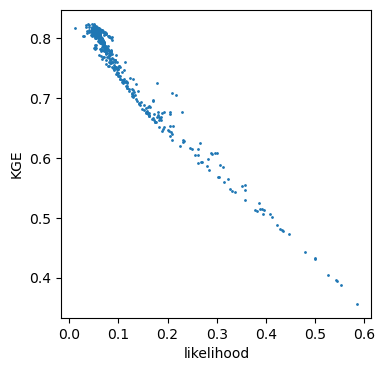

In [37]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(pars.like1, pars.KGE, s=1)
ax.set(xlabel='likelihood',
       ylabel='KGE');

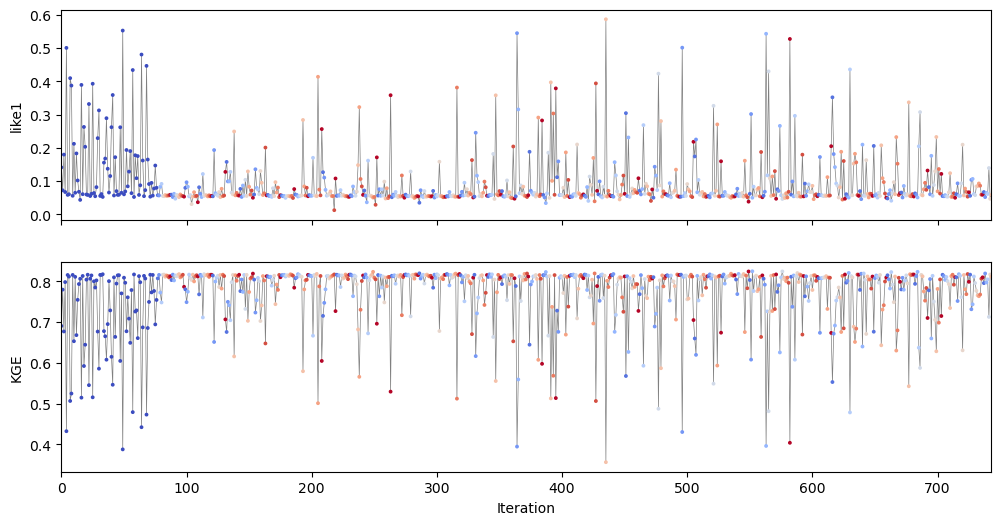

In [38]:
# Plot how the objective function was minimized during sampling
fig, axes = plt.subplots(nrows=2, figsize=(12, 6), sharex=True)
for ax, var in zip(axes, ['like1', 'KGE']):
    ax.plot(pars[var], c='gray', lw=.5, zorder=0)
    ax.scatter(pars.index, pars[var], c=pars.chain, cmap='coolwarm', zorder=2, s=3)
    ax.set_ylabel(var)
    if ax == axes[-1]:
        ax.set(xlabel="Iteration",
               xlim=(0, pars.index.max()));
# fig.savefig("SCEUA_objectivefunctiontrace.png", dpi=150);

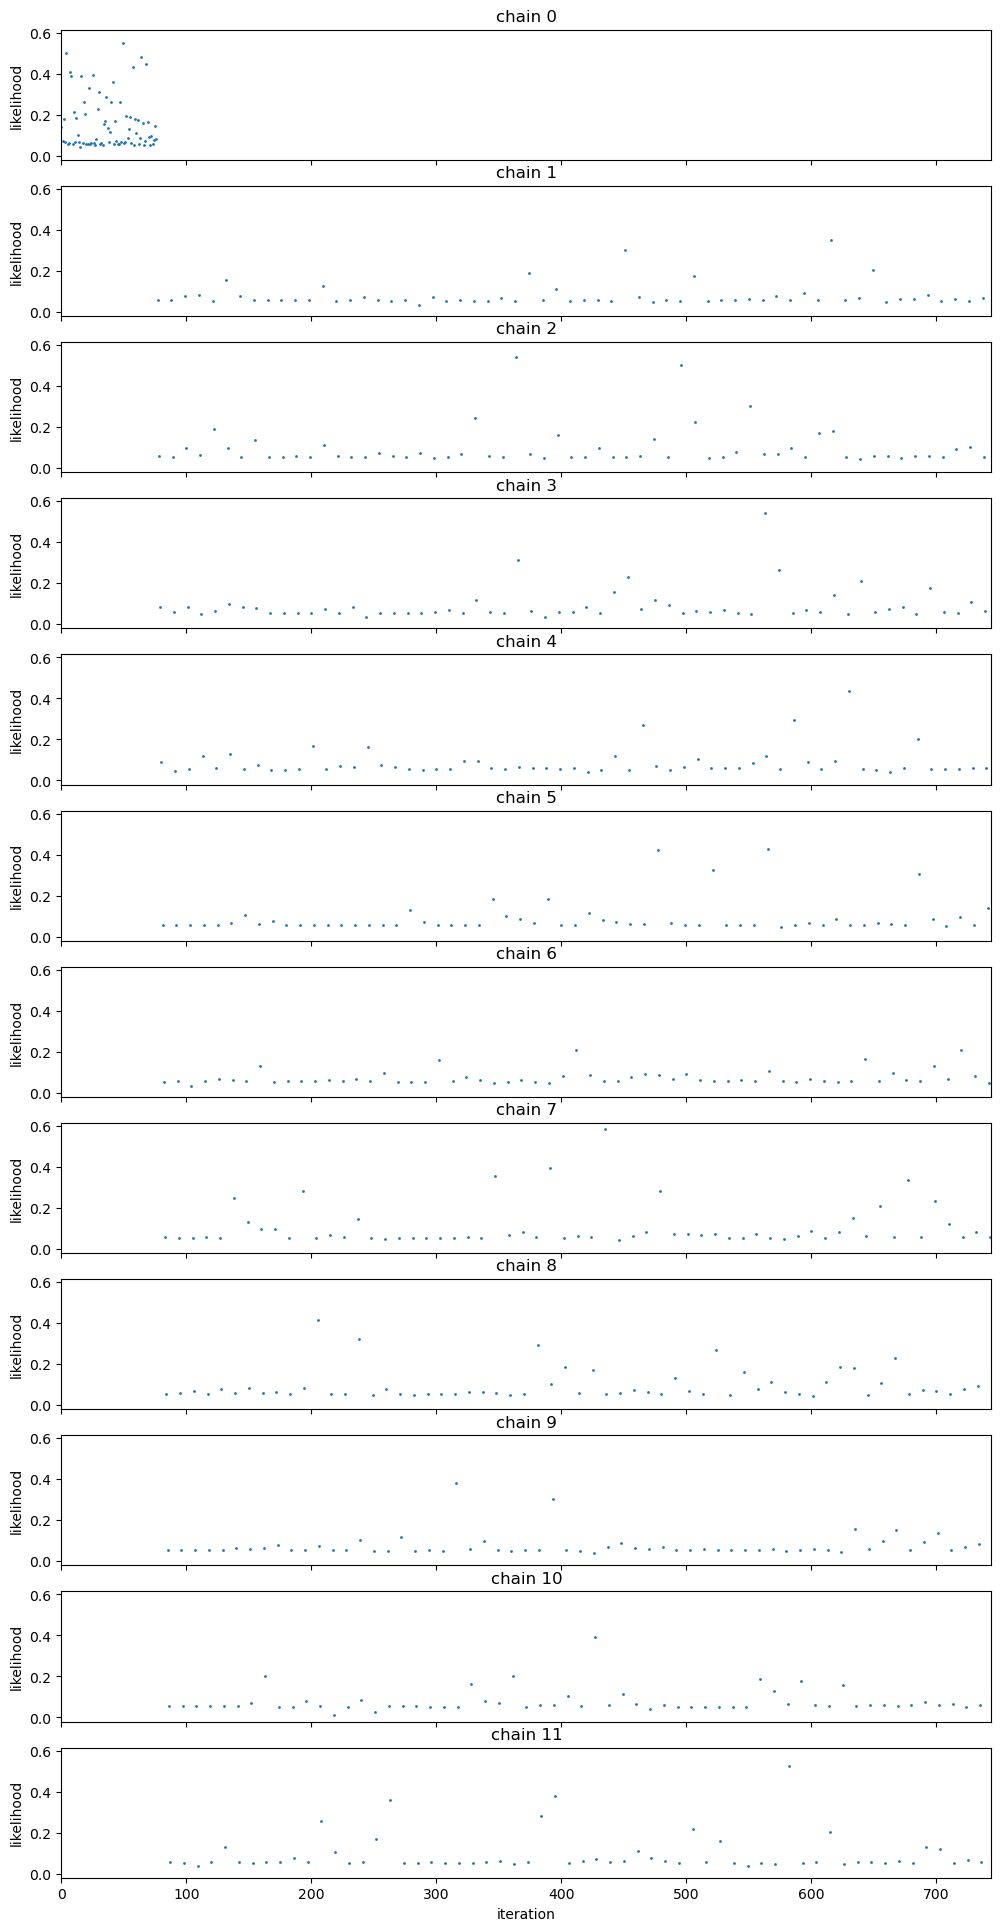

In [46]:
chains = pars.chain.unique()
fig, axes = plt.subplots(nrows=len(chains), figsize=(12, 2 * len(chains)), sharex=True, sharey=True)
for ax, chain in zip(axes, chains):
    aux = pars.loc[pars.chain == chain, 'like1']
    ax.scatter(aux.index, aux, s=1)
    ax.set_title(f'chain {chain:.0f}')
    ax.set_ylabel('likelihood')
    if ax == axes[-1]:
        ax.set(xlim=(0, pars.shape[0]),
               xlabel='iteration',
               ylim=(-.02, None))

In [44]:
best_iter = pars.like1.idxmin()
best_of = pars.loc[best_iter, 'KGE']
parnames = [col[3:] for col in cols if col.startswith('par')]
parvalues = {par: pars.loc[best_iter, par] for par in parnames}
print(f'iteration {best_iter} got the highest performance:\tKGE = {best_of:.3f}')
#print('best parameters:\nalpha = {0:.3f}\nbeta  = {1:.3f}\nk = {2:.3f}'.format(alpha, beta, k))

iteration 218 got the highest performance:	KGE = 0.817


In [45]:
parvalues

{'FFn': 0.53150773,
 'FFf': 0.8655958,
 'QQn': 0.20651262,
 'QQf': 0.9000185,
 'k': 1.0941749}

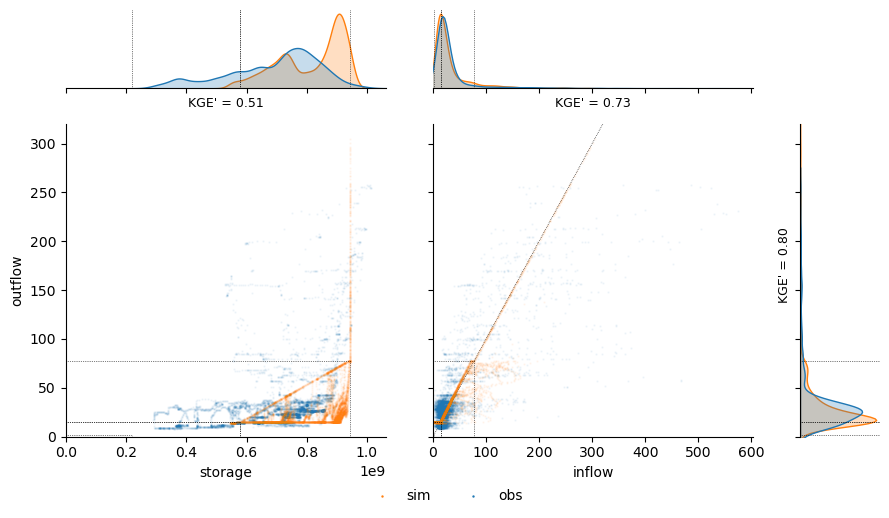

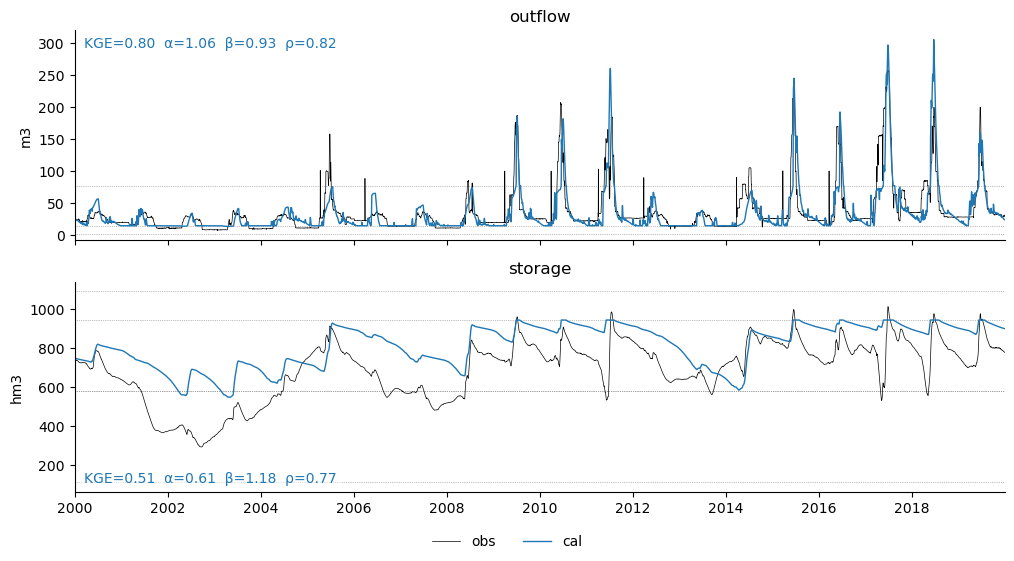

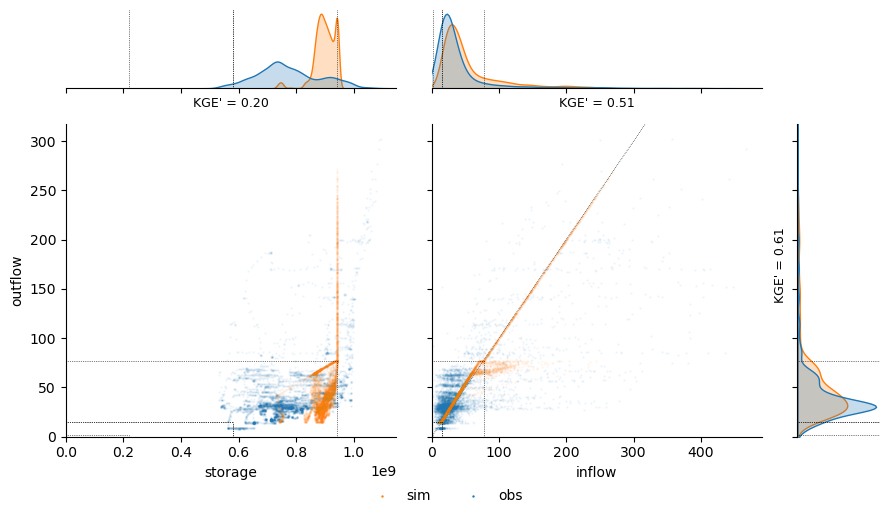

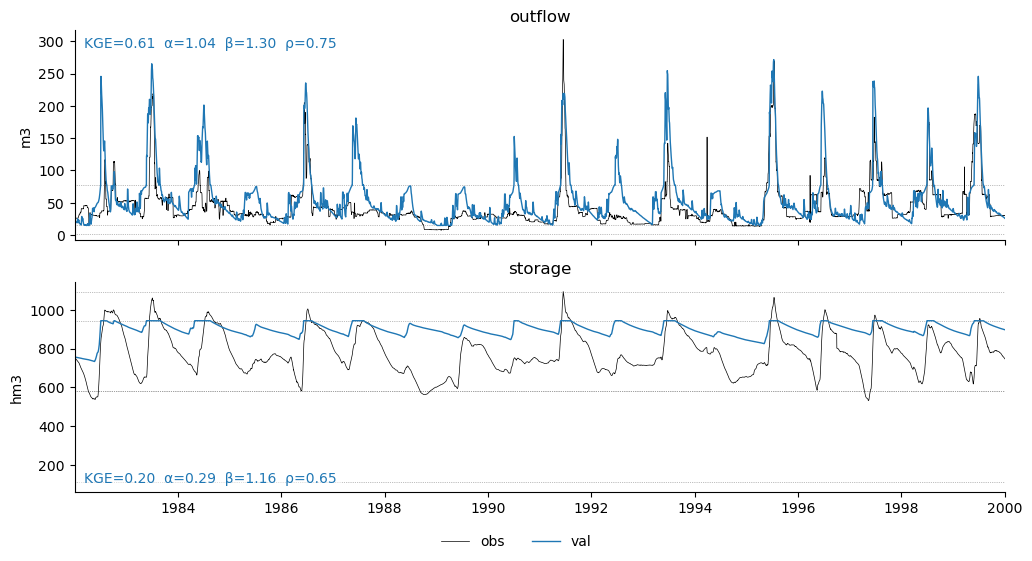

In [54]:
# declare the reservoir
Vn, Vf = [parvalues[var] * Vtot for var in ['FFn', 'FFf']]
Qn, Qf = [obs.inflow.quantile(parvalues[var]) for var in ['QQn', 'QQf']]
k = parvalues['k']
res_cal = Lisflood(Vc, Vn, Vn, Vf, Vtot, Qmin, Qn, Qf)

# simulate calibration period and get performance
y_train = res_cal.simulate(glofas_ts[ResID].inflow[start:end], resops_ts[ResID].storage[start], k=k)
res_cal.scatter(y_train, obs.loc[start:end], norm=False)
res_cal.lineplot({'cal': y_train}, obs.loc[start:end])

# simulate calibration period and get performance
y_test = res_cal.simulate(glofas_ts[ResID].inflow[:start], resops_ts[ResID].storage.iloc[0], k=k)
res_cal.scatter(y_test, obs.loc[:start], norm=False)
res_cal.lineplot({'val': y_test}, obs)

In [63]:
import seaborn as sns

In [83]:
parvalues

{'FFn': 0.53150773,
 'FFf': 0.8655958,
 'QQn': 0.20651262,
 'QQf': 0.9000185,
 'k': 1.0941749}

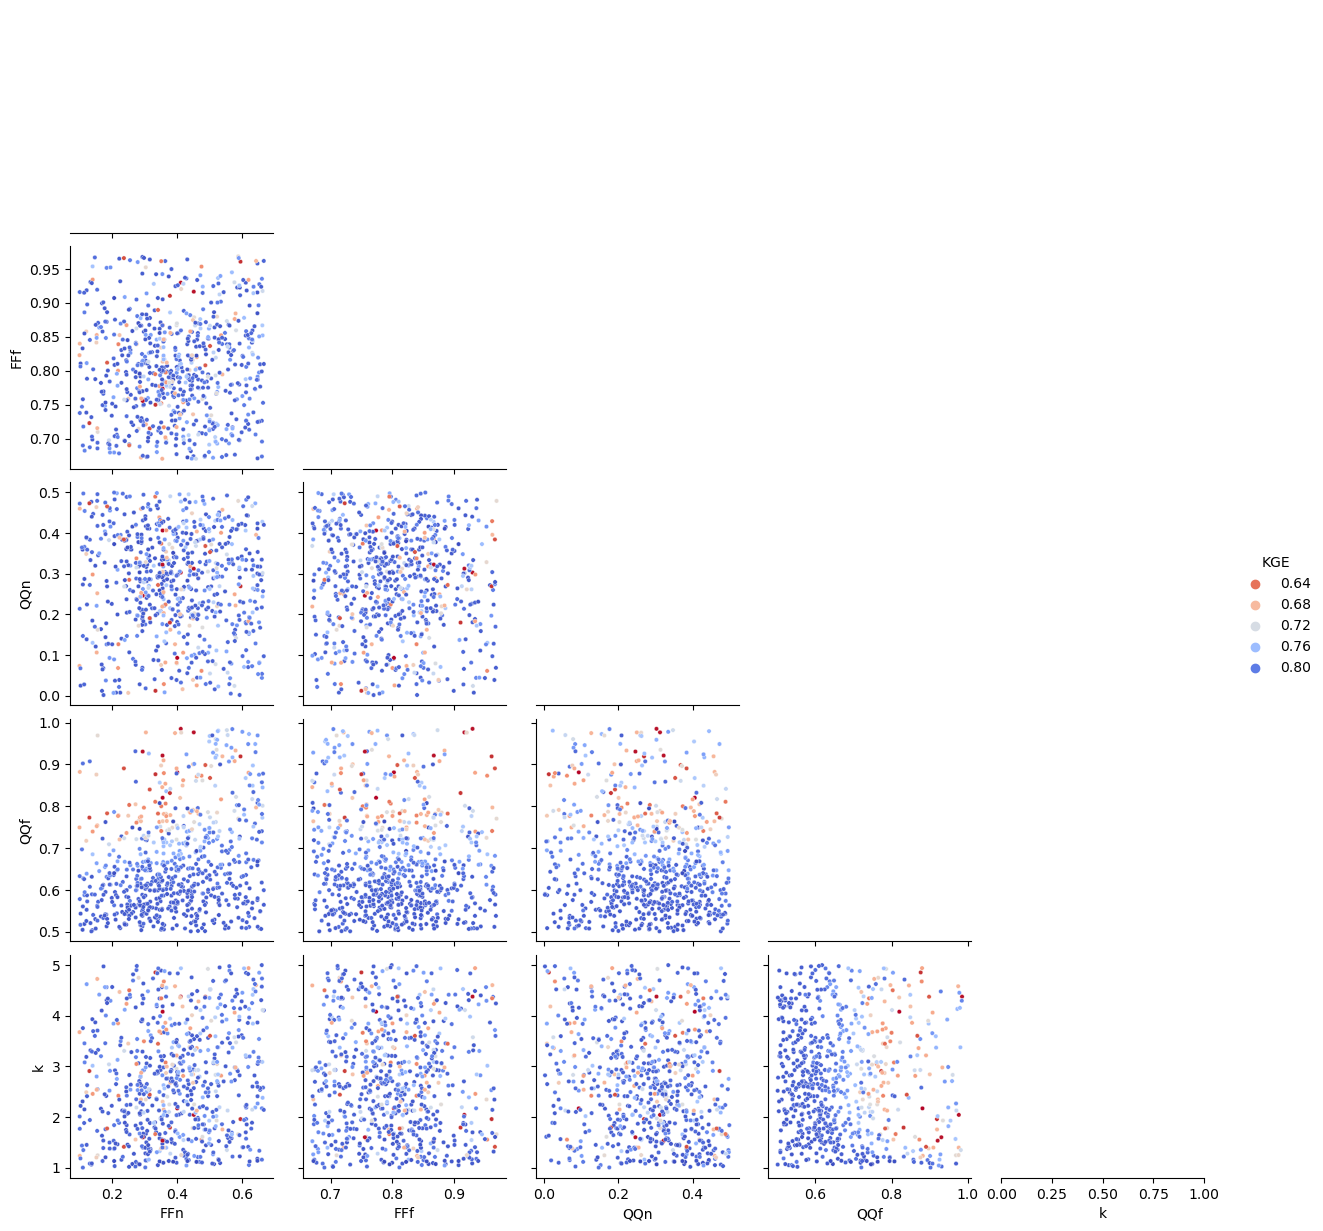

In [82]:
sns.pairplot(pars[pars.KGE > 0.6], vars=parnames, hue='KGE', palette='coolwarm_r', plot_kws={'s': 10}, corner=True);

NameError: name 'results' is not defined

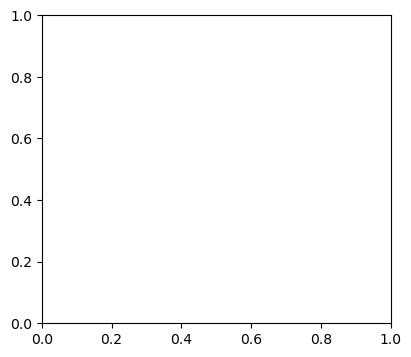

In [84]:
fig, ax = plt.subplots(figsize=(4.5, 4))
sct = ax.scatter(results.alpha, results.beta, s=1, c=results.KGE, cmap='viridis')
ax.set(xlabel='alpha',
       xlim=(0, 1),
       ylabel='beta',
       ylim=(.25, 2));
cbar = plt.colorbar(sct, shrink=.666)
cbar.set_label('KGE (-)')

In [ ]:
fig, ax = plt.subplots(figsize=(4.5, 4))
sct = ax.scatter(results.alpha, results.beta, s=1, c=results.KGE, cmap='viridis')
ax.set(xlabel='alpha',
       xlim=(0, 1),
       ylabel='beta',
       ylim=(.25, 2));
cbar = plt.colorbar(sct, shrink=.666)
cbar.set_label('KGE (-)')

In [ ]:
# declare the reservoir with the effect of the parameters in 'x'
Vn_adj = Vn + alpha * (Vf - Vn)
#Qn = np.max(self.Qn * x[1], self.Qmin + .01)
Qn = Qn * beta
res = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn, Qnd)

sim = res.simulate(train.inflow, train.storage[0])

kge(train.outflow, sim.outflow)

In [ ]:
KGE(train.outflow, sim.outflow)

In [ ]:
plt.plot(train.outflow)
plt.plot(sim.outflow);

In [ ]:
pars = spotpy.analyser.get_best_paradmeterset(results)
pars

In [ ]:
# Plot the best model run
# Find the run_id with the minimal objective function value
bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)

bestindex, bestobjf

In [ ]:
# Select best model run
best_model_run = results[bestindex]

In [ ]:
best_model_run

In [ ]:
# Filter results for simulation results
fields = [word for word in best_model_run.dtype.names if word.startswith("sim")]
best_simulation = list(best_model_run[fields])

In [ ]:
fields

In [ ]:
fig = plt.figure(figsize=(9, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(
    best_simulation,
    color="black",
    linestyle="solid",
    label="Best objf.=" + str(bestobjf),
)
ax.plot(setup.evaluation(), "r.", markersize=3, label="Observation data")
plt.xlabel("Number of Observation Points")
plt.ylabel("Discharge [l s-1]")
plt.legend(loc="upper right");
# fig.savefig("SCEUA_best_modelrun.png", dpi=150);